<a href="https://colab.research.google.com/github/Lbelt/pcse/blob/master/Model_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Model Template
---

A notebook to create the graph models in python
 
 It is organized as follow:
 1. Code to create the graph
 2. Example 1
 3. Example 2
 4. Your Model

## Quick Start
----
When you first open the notebook run the cell under "Code to create the graph" section.

Then **under the Your Model section**
1. Fill the list Graph_Properties with your model
2. Once it is filled, run the cell and check if it works

## HOW TO 
----
<font color='red'>THE FORMATTING IS ESSENTIAL</font>

The code reads the Graph_Properties list. It is a **list** of **nodes** that fully defines the graph.


The list is as follow:
```python
Graph_Properties = [node_1, node_2, node_3]
```
The nodes are defined by a **dictionnary** of properties:

Two types of nodes are possible:

1. For a non computationnal node (input, parameter):

```python
node_1 = {'type': 'input',
          'unit': '$',
          'code': 'Var 1',
          'name': 'Variable 1'
          }
```      

2. For computationnal nodes (variables, outputs)

```python
node_2 = {'type': 'variable', 
          'code': 'Var 2',
          'name': 'Variable 2',
          'unit': '$/capita',
          'in': ['Par 1', 'Var 1'],
          'compuration': {'name': 'Par 1 * Var 1',
                          'formula': None}
          }
```


See examples for more details !


## Code to create the graph
Do not modify !

In [2]:
import networkx as nx
import graphviz
import numpy as np
import pandas as pd


draw_properties = {
    'fillcolor': {'input': '#e76f51',
             'parameter': '#e9c46a',
             'variable': '#f4a261',
             'output': '#2a9d8f',
             'computationnal': '#e76f51'},
    'fontcolor': {'input': '#eeeeee',
             'parameter': '#eeeeee',
             'variable': '#eeeeee',
             'output': '#eeeeee',
             'computationnal': '#000000'},
    'color': {'input': '#eeeeee',
             'parameter': '#eeeeee',
             'variable': '#eeeeee',
             'output': '#eeeeee',
             'computationnal': '#A9A9A9'},
    'style': {'input': 'filled',
             'parameter': 'filled',
             'variable': 'filled',
             'output': 'filled',
             'computationnal': ''},
}

class GraphModel(nx.DiGraph):

    def __init__(self, graph_specifications):
        super(GraphModel, self).__init__()
        nodes, edges = self.parse_specifications(graph_specifications)
        self.check(nodes, edges)
        self.make_graph(edges, nodes)

    def check(self, nodes, edges):
        node_set = set([n[0] for n in nodes])
        edge_set = set([e[0] for e in edges])
        edge_set.remove('ROOT')
        diff = edge_set - node_set
        assert edge_set <= node_set, f"{diff} is used in a computation but is not defined"
        
    def parse_specifications(self, graph_specifications):
        edges, nodes = [], [('ROOT')]

        for raw_node in graph_specifications:
            node = (raw_node['id'], {k: raw_node[k] for k in ('type', 'unit', 'name')})
            nodes.append(node)

            if 'computation' in raw_node:
                node_id = f"{raw_node['id']}_comp"
                node_param = {}
                node_param['formula'] = raw_node['computation']['formula']
                node_param['name'] = raw_node['computation']['name']
                node_param['out'] = raw_node['id']
                node_param['in'] = raw_node['in']
                node_param['type'] = 'computationnal'
                node = (node_id, node_param)
                nodes.append(node)

                for in_node in raw_node['in']:
                    edge = (in_node, node_id)
                    edges.append(edge)
                edges.append((node_id, raw_node['id']))

            if raw_node['type'] in ['input']:
                root_edge = ('ROOT', raw_node['id'])
                edges.append(root_edge)


        return nodes, edges

    def make_graph(self, edges, nodes):
        self.add_nodes_from(nodes)
        self.add_edges_from(edges)
        return None
            
    def draw_node(self, dot, node, draw_properties):
        if node[0] != 'ROOT':
            node_id, label, node_type = node[0], node[1]['name'], node[1]['type']
            
            if node_type != 'computationnal':
                label = f"{label} \n ({node_id})"
                if 'value' in node[1]:
                    value = node[1]['value']
                    label = f"{label} \n {value}"
        
            dot.node(node_id, node_id, {"shape": "rectangle", 
                                        "peripheries": "1", 
                                        'label': label,
                                        'fillcolor': draw_properties['fillcolor'][node_type],
                                        'style': draw_properties['style'][node_type],
                                        'color': draw_properties['color'][node_type],
                                        'fontcolor': draw_properties['fontcolor'][node_type],
                                        'fontname': 'roboto'
                                       }
                    )
        
    def draw_edge(self, dot, a, b, draw_properties):
        if a != 'ROOT': # Not drawing root
            dot.edge(a, b, color='#A9A9A9')

    def draw(self, draw_properties):
        dot = graphviz.Digraph(graph_attr={'splines':'ortho'})
        for node in self.nodes(data=True):
                self.draw_node(dot, node, draw_properties)
        for a, b in self.edges:
                self.draw_edge(dot, a, b, draw_properties)
        return dot

    def run(self, inputs, parameters):
        X = inputs
        X.update(parameters)
        comp_nodes = [v for u, v in nx.bfs_edges(self, 'ROOT') if '_comp' in v] # BFS traversal
        for node_id in comp_nodes:
            node = self.nodes[node_id] 
            computation = node['formula']
            out = node['out']
            X[out] = computation(X)
        return X
    
    def draw_computation(self, inputs, parameters, draw_properties):
        X = self.run(inputs, parameters)
        for node_id in X:
            self.nodes[node_id]['value'] = X[node_id]
        dot = self.draw(draw_properties)
        
        for node_id in X: # Ugly, need to find better option for drawing
            del self.nodes[node_id]['value']

        return dot

## Example 1

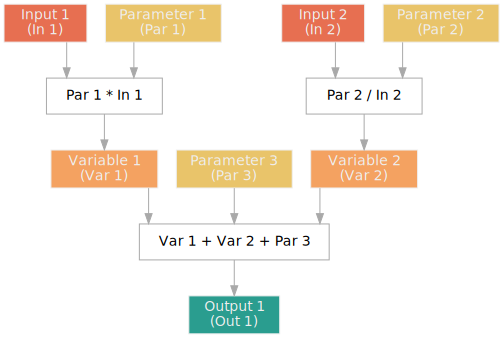

In [3]:
graph_nodes = [
    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': '', # Unit
     'id': 'In 1', # Unique code to define the node
     'name':'Input 1', # Full name
    },
    {'type': 'parameter', # Type of node (input, output, variable, parameter)
     'unit': '', # Unit
     'id': 'Par 1', # Unique code to define the node
     'name':'Parameter 1', # Full name
    },
    {'type': 'variable', 
     'id': 'Var 1',
     'name': 'Variable 1',
     'unit': '',
     'in': ['Par 1', 'In 1'], # Specify what comes into the node
     'computation': {'name': 'Par 1 * In 1', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: X['Par 1'] * X['In 1']} # For now leave the formula field empty
    },
    {'type': 'parameter', # Type of node (input, output, variable, parameter)
     'unit': '', # Unit
     'id': 'Par 3', # Unique code to define the node
     'name':'Parameter 3', # Full name
    },
    {'type': 'output', 
     'id': 'Out 1',
     'name': 'Output 1',
     'unit': '',
     'in': ['Var 1', 'Var 2', 'Par 3'], # Specify what comes into the node
     'computation': {'name': 'Var 1 + Var 2 + Par 3', # When the node is compulationnal specify the computation like this
                    'formula': lambda X: X['Var 1'] + X['Var 2'] + X['Par 3']} # For now leave the formula field empty
    },
    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': '', # Unit
     'id': 'In 2', # Unique code to define the node
     'name':'Input 2', # Full name
    },
    {'type': 'parameter', # Type of node (input, output, variable, parameter)
     'unit': '', # Unit
     'id': 'Par 2', # Unique code to define the node
     'name':'Parameter 2', # Full name
    },
    {'type': 'variable', 
     'id': 'Var 2',
     'name': 'Variable 2',
     'unit': '',
     'in': ['Par 2', 'In 2'], # Specify what comes into the node
     'computation': {'name': 'Par 2 / In 2', # For layout and debugginh
                     'formula': lambda X: X['Par 2'] / X['In 2']} # For now leave the formula field empty
    },
]

GraphModel(graph_nodes).draw(draw_properties)

# Your Model

Replace fields with your own values

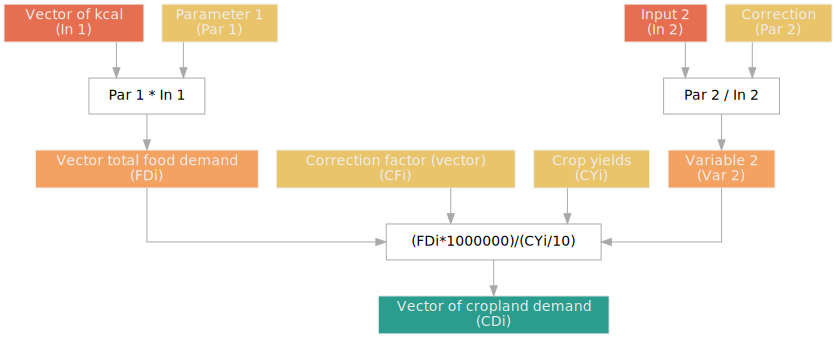

In [18]:
graph_nodes = [
    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': '', # Unit
     'id': 'In 1', # Unique code to define the node
     'name':'Vector of kcal', # Full name
    },
    {'type': 'parameter', # Type of node (input, output, variable, parameter)
     'unit': '', # Unit
     'id': 'Par 1', # Unique code to define the node
     'name':'Parameter 1', # Full name
    },
    {'type': 'variable', 
     'id': 'FDi',
     'name': 'Vector total food demand',
     'unit': '',
     'in': ['Par 1', 'In 1'], # Specify what comes into the node
     'computation': {'name': 'Par 1 * In 1', # When the node is compulationnal specify the computation like this
                    'formula': None} # For now leave the formula field empty
    },
    {'type': 'parameter', # Type of node (input, output, variable, parameter)
     'unit': '', # Unit
     'id': 'CFi', # Unique code to define the node
     'name':'Correction factor (vector)', # Full name
    },


    {'type': 'parameter', # Type of node (input, output, variable, parameter)
     'unit': '', # Unit
     'id': 'CYi', # Unique code to define the node
     'name':'Crop yields', # Full name
    },


    {'type': 'output', 
     'id': 'CDi',
     'name': 'Vector of cropland demand',
     'unit': '',
     'in': ['FDi', 'Var 2', 'CFi', 'CYi'], # Specify what comes into the node
     'computation': {'name': '(FDi*1000000)/(CYi/10)  ', # When the node is compulationnal specify the computation like this
                    'formula': None} # For now leave the formula field empty
    },


    {'type': 'input', # Type of node (input, output, variable, parameter)
     'unit': '', # Unit
     'id': 'In 2', # Unique code to define the node
     'name':'Input 2', # Full name
    },
    {'type': 'parameter', # Type of node (input, output, variable, parameter)
     'unit': '', # Unit
     'id': 'Par 2', # Unique code to define the node
     'name':'Correction', # Full name
    },
    {'type': 'variable', 
     'id': 'Var 2',
     'name': 'Variable 2',
     'unit': '',
     'in': ['Par 2', 'In 2'], # Specify what comes into the node
     'computation': {'name': 'Par 2 / In 2', # For layout and debugginh
                     'formula': None} # For now leave the formula field empty
    },
]

GraphModel(graph_nodes).draw(draw_properties)